<a href="https://colab.research.google.com/github/nepslor/teaching/blob/main/2021SmartGrids/L03_TimeSeriesForecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# L03: Introduction to power forecasting
In this lesson we will go through basic concepts of time-series analysis, visualization and power forecasting techniques. 
Let's start from downloading a dataset containing power measurements and meteorological forecasts relative to a set of 24 power meters located in Rolle (Switzerland).

In [3]:
!pip install wget;
import pandas as pd
import wget
import numpy as np
data = pd.read_pickle(wget.download("https://zenodo.org/record/4549296/files/reduced_dataset.pk?download=1"));

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=8c3bafbd550656e758098d92e024fe15da093e6f33c9751ba776aa41e6e62bee
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


The dataframe contains a set of power series from different meters and the most updated forecasts of the global horizontal irradiance (GHI) and the temperature (T), povided by a numerical weather prediction service. Let's print some rows...

In [ ]:
data.head()

,0307a3cec15787560b7d0ba094f74d1decb2fa72,0f415416ff153479d65f54df3fa9974af46e3a89,1caab5f0e80231e1c6fdefc00edec4fdb6a02c5f,27fbb11689277a30f5db9c71b42e1d3826bd34ff,2ce3e7e1a5365dc54c7f4fc6284f0052397702b9,2d837275047e5fdce39fda42b541dbf6c858a4d1,350c6b9720ebb1e1a04e8f88ad0fa114c2af77b3,39f06481738604cb5916dce15639e380514b99ca,432650b919537d23cb4054fdb85a07eecaa4524c,49228b90116c6075fabcd8a1cf0e48e016373614,4db83178615678a918dfa6a38ae6e23de7a2d39a,5e9c55269b890ad82c8ebbd146ea2a563fe768ce,75d0930659fc8dcdaffed6c60d5871a969a76a87,7bf877fd51c1c6db07c1fb0255eac4540030f28f,7ebc4dd008e424c2510c6581a195524563b00ee9,89819f031b89125c8c4b364317478f078925fe38,a0ab25616dde3d31062ade71f866faa3b1e8e18f,a4656735af4aa0ba2e4758f8d4f6e411cfc55097,a52f9650e9aa3d60e43792eb2574e0e76bb00aaf,b3e1bf5d8d0337b42f972ca11beafea062bd99be,c41c064e0aa78571b028c8673ebe7abd59d0e6d8,c55a669913fe883d9ec913821688656ea8e4c884,da3ac5e45e56e0e2263f39f38c033366f5d1e0c4,fe2245a4afe0afc24d215dd4abd2ffb34610dd27,all,S1,S2,S11,S12,S21,S22,ghi_backwards,temperature
2018-01-13 00:10:00+00:00,9.786000,20.518000,10.653333,19.190333,23.088333,41.712000,24.278000,12.349333,28.300333,11.307000,26.107000,19.024333,27.199333,17.826333,23.517000,41.610000,42.170000,15.568000,39.930667,28.958000,54.739000,9.649000,16.355000,17.921333,581.757667,246.314000,335.443667,124.948000,121.366000,167.890667,167.553000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0361272897446...","[3.6288461538461543, 3.589157030333501, 3.4878..."
2018-01-13 00:20:00+00:00,11.190000,20.086333,9.367333,19.794000,22.374667,43.572667,23.853333,10.230667,30.275333,13.225333,25.436667,20.779000,25.735667,19.846000,19.520667,41.192000,44.210000,14.850000,38.951667,31.954000,53.360333,8.920667,15.810667,16.359333,580.896333,250.185333,330.711000,126.385000,123.800333,165.354333,165.356667,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.9360517716272...","[3.6256410256410265, 3.5733366851013924, 3.477..."
2018-01-13 00:30:00+00:00,10.712333,19.977333,12.999333,19.607000,22.249000,39.306333,23.938667,10.445000,31.299667,11.968000,26.358667,22.044667,26.209000,17.409333,20.409000,41.206333,43.191667,14.735667,40.084667,29.783333,55.757667,9.343667,14.568667,16.344667,579.949667,250.906000,329.043667,124.851333,126.054667,163.161000,165.882667,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.3870873646209...","[3.620769230769231, 3.554524886877828, 3.46849..."
2018-01-13 00:40:00+00:00,12.445000,20.049667,11.751333,19.233333,22.755333,35.916333,24.074000,9.907000,29.984000,12.003667,29.911000,19.336667,26.046333,16.540667,24.510667,41.764333,43.024667,15.357333,37.047667,28.658000,41.366333,9.045667,14.575667,24.532000,569.836667,247.367333,322.469333,122.151000,125.216333,167.244000,155.225333,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.076547987698...","[3.6146153846153846, 3.53470755823697, 3.45838..."
2018-01-13 00:50:00+00:00,10.487000,19.225333,10.183667,20.226667,22.375333,36.360000,25.039667,10.479667,32.333000,11.688000,29.341333,18.995333,27.370333,17.798000,22.480333,41.120000,43.132667,18.018000,37.376667,25.047667,29.712000,9.094000,15.083667,19.819333,552.787667,246.735000,306.052667,118.858000,127.877000,169.919333,136.133333,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.691747559834...","[3.6075641025641025, 3.515870621752975, 3.4460..."


## Time series visualization
Sometimes, time series data can have seasonalities. If seasonalities are present, we can use them as an embedding for the time series; this can help compressing (and thus predicting) the signal. 

A simple and effective way to find seasonalities is to use the autocorrelation function:
$$a(x, k)=\frac{1}{\sigma_x^{2}} \frac{1}{T-k} \sum_{t=1}^{T-k}\left(x_{t}-\mu_{x}\right)\left(x_{t+k}-\mu_{x}\right)$$

Let's see if we can spot seasonalities in the total aggregated power contained in the ['all'] column of the dataframe


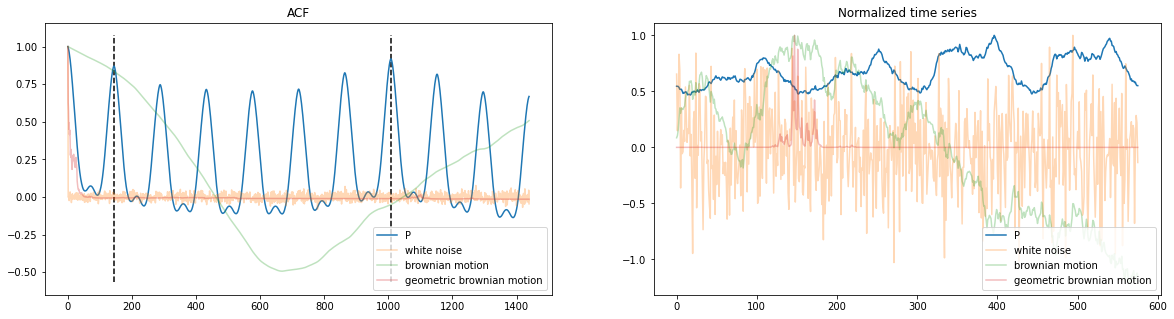

In [4]:
import matplotlib.pyplot as plt
from functools import reduce

np.random.seed(0)
samples_per_day = 144
max_lag = samples_per_day * 10
white_noise = np.random.randn(max_lag*2)
brownian_motion = np.cumsum(white_noise)
geometric_brownian_motion = np.cumprod(np.exp(white_noise))

fig, ax = plt.subplots(1, 2, figsize=(20,5))
ax[0].plot([data['all'].autocorr(i) for i in range(max_lag)], label='P')
ax[0].plot([pd.Series(white_noise).autocorr(i) for i in range(max_lag)], label='white noise', alpha=0.3)
ax[0].plot([pd.Series(brownian_motion).autocorr(i) for i in range(max_lag)], label='brownian motion', alpha=0.3)
ax[0].plot([pd.Series(geometric_brownian_motion).autocorr(i) for i in range(max_lag)], label='geometric brownian motion', alpha=0.3)
ylims = ax[0].get_ylim(); ax[0].vlines(144, *ylims, linestyles='--'); ax[0].vlines(144*7, *ylims, linestyles='--')
ax[0].legend(loc="lower right")
ax[0].set_title('ACF')

ax[1].plot(data['all'].iloc[:144*4].values/data['all'].iloc[:144*4].max(), label='P')
ax[1].plot(white_noise[:144*4]/np.max(white_noise[:144*4]), label='white noise', alpha=0.3)
ax[1].plot(brownian_motion[:144*4]/np.max(brownian_motion[:144*4]), label='brownian motion', alpha=0.3)
ax[1].plot(geometric_brownian_motion[:144*4]/np.max(geometric_brownian_motion[:144*4]), label='geometric brownian motion', alpha=0.3)
ax[1].legend(loc="lower right");
ax[1].set_title('Normalized time series');


Strong seasonalities can be spotted at 144 steps intervals (1 day at 10 min sampling time), with a second local maximum after 7 days (the second dashed vertical line), indicating a strong weekly seasonality. As a comparison, the orange and the green lines represent the autocorrelations of white noise (iid samples from a noraml distribution) and of brownian motion.

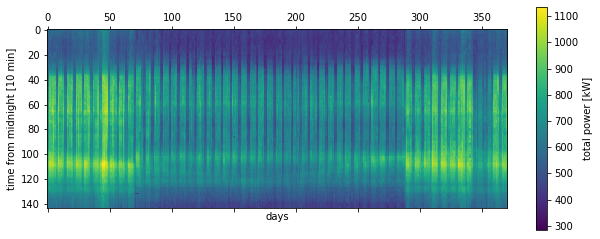

In [18]:

l = len(data['all'])
n_max = int(l/144)*144
d_mat = data['all'].values[:n_max].reshape(-1, 144)
plt.matshow(d_mat.T)
plt.xlabel('days')
plt.ylabel('time from midnight [10 min]')
plt.colorbar(label='total power [kW]');

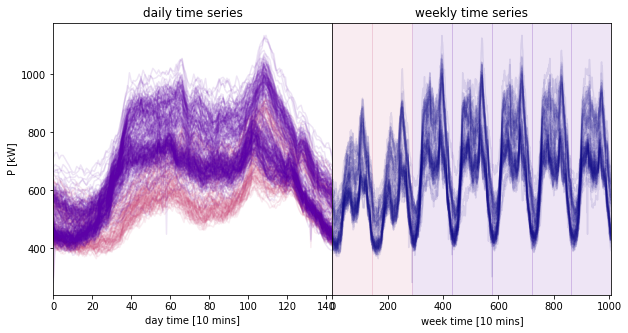

In [17]:
colors = plt.get_cmap('plasma',7)
fig, ax = plt.subplots(1,2, figsize=(10,5))
plt.subplots_adjust(wspace=0)
[ax[0].plot(data['all'].values[:n_max].reshape(-1, 144).T[:, i::7], c=colors(1 if i>1 else 3), alpha=0.1) for i in range(7)];
ax[0].set_xlim(0,143)
ax[0].set_xlabel('day time [10 mins]')
ax[0].set_ylabel('P [kW]')
ax[0].set_title('daily time series')

ax[1].plot(data['all'].values[:n_max].reshape(-1, 144*7).T, alpha=0.1, color=colors(0));
[ax[1].axvspan(144*i, 144*(i+1), alpha=0.1, color=colors(1 if i>1 else 3)) for i in range(7)];
ax[1].set_xlim(0,1008)
ax[1].set_yticks([]);
ax[1].set_xlabel('week time [10 mins]');
ax[1].set_title('weekly time series');
